<div style="text-align: center;">
  <a href="#">
    <img src="../imagenes/Logo_bicimad.png"
         style="width: 800px; max-width: 100%; height: auto;" />
  </a>
</div>

# Análisis Exploratorio de Datos (EDA) de BiciMAD

------------

**Índice** 

1. [Librerias](#1.-Librerias)
2. [EDA Exploratory Data Análisis](#2.-EDA-Exploratory-Data-Analisis)
    - [Proceso de ETL y Funciones](##-Proceso-de-ETL-y-Funciones)
    - [Hipótesis 1: Ubicación Estrategica de Estaciones](##-Hipotesis-1-Ubicacion-estrategica-de-estaciones)
    - [Hipótesis 2: Disponibilidad en las horas pico](##-Hipotesis-2-Disponibilidad-en-horas-pico)
    - [Hipótesis 3: Uso turístico del sistema](##-Hipotesis-3-Uso-turistico-del-sistema)
    - [Hipótesis 4: Mayor uso los fines de semana](##-Hipotesis-4-Mayor-uso-en-fines-de-semana)



# 1. Librerias

In [112]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import notebooks.utils as u
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import folium
from folium import plugins
import numpy as np 
import plotly.graph_objects as go
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from datetime import datetime, timedelta


import warnings
warnings.filterwarnings("ignore")

pd.set_option('max_colwidth', None)

plt.style.use('seaborn-v0_8')

# 2. EDA Exploratory Data Analisis

<div style="text-align: center;">
  <a href="#">
    <img src="../imagenes/EDA-in-Data-Science.png"
         style="width: 600px; max-width: 100%; height: auto;" />
  </a>
</div>

### Objetivo:

El propósito de este proyecto es evaluar la utilidad y eficiencia del sistema de bicicletas públicas BiciMAD como alternativa de movilidad sostenible en la ciudad de Madrid. Buscamos entender los patrones de uso del sistema, su estacionalidad, y cómo se relaciona con el flujo peatonal y los hábitos de movilidad urbana. A través de este análisis, pretendemos valorar si las estaciones de BiciMAD están estratégicamente ubicadas en zonas de alta demanda, así como identificar oportunidades de mejora que fomenten una movilidad más activa, equitativa y respetuosa con el medio ambiente.

**Hipótesis**

1. <span style="color:darkblue"><strong>Ubicación estratégica de estaciones:</strong></span> Las estaciones de BiciMAD están situadas en zonas clave de la ciudad, coincidiendo con áreas de alto tránsito peatonal, lo que sugiere una planificación orientada a la accesibilidad y el uso intensivo.

2. <span style="color:darkblue"><strong>Disponibilidad en horas pico:</strong></span> Existe una adecuada disponibilidad de bicicletas durante las horas punta, lo que indicaría que el sistema responde correctamente a los momentos de mayor demanda de los usuarios.

3. <span style="color:darkblue"><strong>Uso turístico del sistema:</strong></span> Una parte significativa del uso de BiciMAD está asociada al turismo, especialmente en zonas céntricas o de interés cultural y durante temporadas altas.

4. <span style="color:darkblue"><strong>Mayor uso en fines de semana:</strong></span> El sistema es utilizado con mayor frecuencia durante los fines de semana, lo cual puede estar relacionado con actividades recreativas, turísticas o de ocio.

## Proceso de ETL y Funciones

Para el desarrollo de este proyecto hemos utilizado 2 notebooks que nos ayudarnos a preparar la información previa de cara a la validación de las hipótesis. Estos notebooks son:

- [Notebook Limpieza y Tratamiento de Datos.](./notebooks/Notebook_Limpieza_Fuentes.ipynb)
- [Notebook Funciones.](./notebooks/utils.py)

### Notebook Limpieza y Tratamiento de Datos

Dentro de este Notebook, tienes por cada fuente de datos todo el tratamiento que han pasado tanto de filtrado, tratamiento de Nan (si aplica) y guardado de csv para el proceso de validación de hipótesis.

### Notebook Funciones

Tenemos 5 funciones que se han desarrollado para el proceso de ETL y EDA las cuales explicaremos cada una:

1. **Convertir Fecha.**
~~~
def convertir_fecha(fecha:int, formato:str="%Y-%m-%d"):
    ''' 
    Esta es un funcion para convertir un fecha numerica a fecha.

    Input:
        fecha:int
    
    Output:
        fecha_convertida:date ("%Y-%m-%d")
    '''
    fecha_base = datetime(1899, 12, 30)
    fecha_convertida = (fecha_base + timedelta(days=fecha)).strftime(formato)
    fecha_convertida = datetime.strptime(fecha_convertida, '%Y-%m-%d')
    return fecha_convertida
~~~
Esta función la creamos con el fin de parsear unas fechas que venian en formado numéricos como por ejemplo: 45759 (como en excel). Basicamente esta función toma como parámetro un número entero y añade a la fecha 30 de diciembre de 1899 (es la fecha mínima que tiene excel si quieres saber más [aquí](https://www.iwpcug.org/docs/18991230.php)) tu parámetro fecha y la formatea de forma que quede como una fecha Año-Mes-Día.

2. **Situación Estaciones.**
~~~
def call_situacion_estaciones(directorio:str='../data/Datos Originales/Situacion de Estaciones'):
    ''' 
    Funcion para leer varios ficheros de json de un directorio.

    Input:
        directorio:str
    
    Output:
        bases:DataFrame
    '''
    bases = pd.DataFrame()
    for archivo in os.listdir(directorio):
        lista = []
        ruta_completa = os.path.join(directorio, archivo)
        with open(ruta_completa, 'r', encoding='utf-8') as f:
            for linea in f:
                valores = json.loads(linea)
                lista.append(valores)
        df = pd.DataFrame(lista)

        df_exploded = df.explode('stations', ignore_index=True) # Funcion que convierte lista en registros de la tabla
        stations_df = pd.json_normalize(df_exploded['stations']) # Normalize semi-structured JSON data into a flat table.
        stations_df['_id'] = df_exploded['_id']
        bases = pd.concat([bases,stations_df], ignore_index=True)
    return bases
~~~
Esta función la creamos con el fin de procesar varios archivos JSON en un dataframe. EL parámetro de entrada es una ruta, donde tienes todos lo JSON que vas a leer. Una vez entras en el directorio, iteramos por cada archivo JSON para cargar cada linea en una lista y a esta lista la guardamos en el dataframe vacio. Una vez tengas todos los archivos cargados, tienes que descomponer esta lista en columnas  y lo  normaliza, aqui un ejemplo de la [documentación](https://pandas.pydata.org/docs/reference/api/pandas.json_normalize.html):
~~~
>>> data = [
...     {"id": 1, "name": {"first": "Coleen", "last": "Volk"}},
...     {"name": {"given": "Mark", "family": "Regner"}},
...     {"id": 2, "name": "Faye Raker"},
... ]
>>> pd.json_normalize(data)
    id name.first name.last name.given name.family        name
0  1.0     Coleen      Volk        NaN         NaN         NaN
1  NaN        NaN       NaN       Mark      Regner         NaN
2  2.0        NaN       NaN        NaN         NaN  Faye Raker
~~~

Una vez normalizado el dataframe tendrá las columnas pobladas y podremos concatenar con los datos del dataframe bases.


3. **Uso Bicicletas.**

~~~

def call_uso_bicicletas(directorio:str='../data/Datos Originales/Datos usos'):
    ''' 
    Funcion para leer varios ficheros de csv de un directorio.

    Input:
        directorio:str
    
    Output:
        bases:DataFrame
    '''
    bases = pd.DataFrame()
    for archivo in os.listdir(directorio):
        records = []
        ruta_completa = os.path.join(directorio, archivo)
        with open(ruta_completa, 'r', encoding='utf-8') as f:
            record = pd.read_csv(f, sep=";", comment=";", skip_blank_lines=True, dtype={"station_unlock": str})
            record.dropna(how="all", inplace=True)
            bases = pd.concat([bases,record], ignore_index=True)
    return bases
~~~

Esta función la creamos con el fin de procesar varios archivos csv en un dataframe. EL parámetro de entrada es una ruta, donde tienes todos lo csv que vas a leer. Una vez entras en el directorio, iteramos por cada archivo para cargalo (algo especial de estos csv es que tenian lineas de comentarios comment=";") quitamos las filas en null  y podremos concatenar con los datos del dataframe bases.

Ejemplo de CSV:
~~~
fecha;idTrip;idBike;fleet;trip_minutes;geolocation_unlock;address_unlock;unlock_date;locktype;unlocktype;geolocation_lock;address_lock;lock_date;station_unlock;dock_unlock;unlock_station_name;station_lock;dock_lock;lock_station_name
;;;;;;;;;;;;;;;;;;
2022-01-01;489978239_1718_2022-01-01T00:18:37;1718;1;16.28;{'type': 'Point', 'coordinates': [-3.6714166, 40.4318611]};;2022-01-01T00:02:20;STATION;STATION;{'type': 'Point', 'coordinates': [-3.688398, 40.419752]};;2022-01-01T00:18:37;200;3;Avenida de los Toreros;64;4;Plaza de la Independencia
;;;;;;;;;;;;;;;;;;
~~~

4. **Limpieza de Coordenadas.**

~~~
def limpiar_coordenadas(coord:str):
    ''' 
    Función de lipieza que limpia las coordenadas.

    Input:
        coord:str
    
    Output:
        coord_cambiada:str
    '''
    coord_str = coord.replace(".", "")
    if len(coord_str) >= 7:
        coord_cambiada = float(coord_str[:2] + "." + coord_str[2:])
    elif len(coord_str) >= 6:
        coord_cambiada = float(coord_str[:1] + "." + coord_str[1:])
    return coord_cambiada

~~~
Esta función fue creada para un tratamiento especial de un csv de aforos de personas y bicicletas que sus puntos de latitud y longitud venian en un formato específico 40.405.472;-3.711.961 por lo que nos toco dar un tratamiento a sus datos. Esta función toma como parámetro un string, reeplaza los . por nada y hace lógicas para las coordenadas según su logitud:

- Si la coordenada tiene un tamaño >= 7 --> coge los primeros 2 digitos coloca un punto y despues el resto  convirtiendolo en float.
- Si la coordenada tiene un tamaño >= 6 --> coge el primer digito coloca un punto y despues el resto  convirtiendolo en float.

5. **Corrector de Letras.**
~~~

def percentile(n:int):
    ''' 
    Funcion para calcular varios percentiles al usar un group by.

    Input:
        n:int --> numero de percentil
    
    Output:
        percentile_:float
    '''
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_
~~~
Esta función fue creada para el calculo de los percentiles en los group by, toma como parámetro el número de percentil y te da el valor.

6. **Corrector de Letras.**

~~~
def corregir_letras(texto:str):
    ''' 
    Funcion para remplazar letras.

    Input:
        texto:str
    
    Output:
        texto:str
    '''
    mapeo_letras = {'Ã­': 'í', 'Ã©': 'é', 'Ã¡': 'á', 'Ã±': 'ñ', 'Ã³':'ó'}
    for clave, valor in mapeo_letras.items():
        texto = texto.replace(clave, valor)
    return texto
~~~
Esta función fue creada para corregir unos CSV que venian con el formato incorrecto, por lo que toma como input un texto y reeplaza con el diccionario el vamor que corresponde. 

## Hipotesis 1 Ubicacion estrategica de estaciones

Para poder evaluar esta hipótesis tenemos 2 fuentes de datos (del ayuntamiento de Madrid) que nos ayudarán a comprobar si realmente esta hipótesis es cierta.

**1. Detalle de Aforo de personas en 2023** &rarr; Esta información nos detalle por calle, fecha y hora cuanto ha sido la concentración o aforo de peatones. 

**2. Detalle de Bases de bicicletas en Madrid** &rarr; Esta información, actualizada en el 2020, nos detalla por cada estación de bicicletas su ubicación y detalles como anclajes.

In [113]:
''' 
Lectura de fuentes de Datos

'''

aforo_personas_2023 = pd.read_csv('./data/Datos Tratados/aforo_personas_2023.csv')

mapa_bases_bicicletas = pd.read_csv('./data/Datos Tratados/mapa_bases_bicicletas.csv')

In [114]:
# Nos quedamos como solo ciertas columnas que nos interesa para esta analítica

mapa_bases_bicicletas.drop(columns=['fecha_alta', 'calle', 'numero'], inplace=True)

Lo primero que queriamos analizar es como estos datos de peatones están distribuidos, ya que según esto tomaremos decisiones sobre como actuar con los datos. 

In [115]:
aforo_personas_2023.describe()

,mes,dia_semana,fin_semana,peatones,latitude,longitude
count,190618.000000,190618.000000,190618.000000,190618.000000,190618.000000,190618.000000
mean,7.065959,2.994208,0.287512,730.258208,40.421363,-3.698918
std,3.533688,2.002888,0.452604,1231.733894,0.016530,0.024529
min,1.000000,0.000000,0.000000,0.000000,40.383053,-3.783391
25%,4.000000,1.000000,0.000000,92.000000,40.413387,-3.707464
50%,7.000000,3.000000,0.000000,351.000000,40.419908,-3.700892
75%,10.000000,5.000000,1.000000,809.000000,40.424799,-3.694488
max,12.000000,6.000000,1.000000,24715.000000,40.494945,-3.577728


En una primera vista vemos que tenemos un amplio rango de datos por mes y hora del 2023. Con una media de 730.26 de peatones y su desviación es de 1231.73 lo que muestra que los datos son muy dispersos con respecto a la media. Además, miramos los datos de sus cuartiles,  la media y la mediana está muy alejadas y los valores max con el quartil 3 (75%) tambien lo que nos hace pensar que su distribución tiene una asimetría positiva con una larga cola a la derecha.

Algo más que vale la pena comentar es que para esta analítica descriptiva, es necesario no solo analizar a grandes razgos los datos sino, tambien mirarlos tomando en cuenta su estacionalidad ya que no es lo mismo los peatones que se tiene en meses como verano vs el invierno.

Por esto hemos incluido un gráfico de distribución de violin y sus estadíticos para ver por mes y dias de semana (variable binaria fin de semana si o no) su distribución.

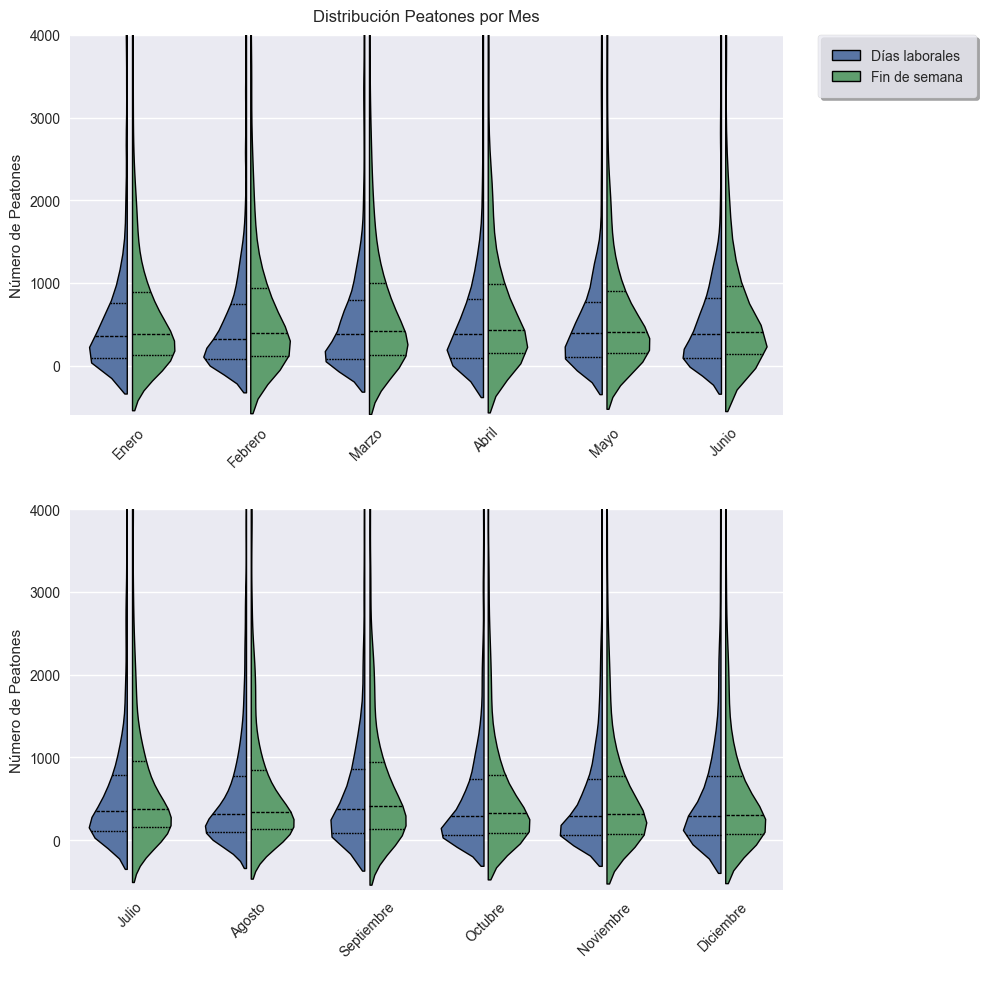

In [116]:
plt.figure(figsize=(10,10))

new_labels = ['Días laborales', 'Fin de semana']

plt.subplot(2, 1, 1)
sns.violinplot(data=aforo_personas_2023[aforo_personas_2023['mes']<7], x='mes', y='peatones', hue='fin_semana', 
               split=True, gap=.1, inner="quart" , linewidth=1, linecolor="k")
plt.title('Distribución Peatones por Mes', pad=10)
plt.xlabel(' ')
plt.ylabel('Número de Peatones')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, new_labels, frameon = True, fancybox=True, framealpha=0.8, shadow=True, borderpad=1, bbox_to_anchor=(1.05, 1), 
           loc='upper left', borderaxespad=0.)
meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio']
plt.xticks(ticks=range(0, 6), labels=meses, rotation=45)
plt.ylim(-600, 4000)



plt.subplot(2, 1, 2)
sns.violinplot(data=aforo_personas_2023[aforo_personas_2023['mes']>=7], x='mes', y='peatones', hue='fin_semana', 
               split=True, gap=.1, inner="quart", legend=False, linewidth=1, linecolor="k")
plt.xlabel(' ')
plt.ylabel('Número de Peatones')
meses = ['Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
plt.xticks(ticks=range(0, 6), labels=meses, rotation=45)
plt.ylim(-600, 4000)



plt.tight_layout()
plt.show()

Como se puede ver en la gráfica la distribución por mes y fin de semana es muy similar, con una asimetría positiva y colas muy largas. Por lo que tomaremos los datos del percentil 75 o más para determinar los punto de afóros más altos. 

In [117]:
# Calculamos el pecentil 75 agrupado por 'direccion', 'mes', 'fin_semana'.

percentil_aforo = aforo_personas_2023.groupby(['direccion', 'mes', 'fin_semana'])['peatones'].aggregate([u.percentile(75)]).reset_index()

In [118]:
# Filtramos el aforo para quedarnos en los puntos cuyo total de peatones sea mayor o igual al percentil 75.

aforo_personas_2023 = pd.merge(aforo_personas_2023, percentil_aforo, on=['direccion', 'mes', 'fin_semana'])

aforo_personas_2023 = aforo_personas_2023[aforo_personas_2023['peatones']>=aforo_personas_2023['percentile_75']]

Un vez identificados los puntos de alta concentración, nos quedamos con los datos de 'direccion', 'latitude', 'longitude' y calculamos la media de estos.

In [119]:
aforo_personas_2023_resumen = aforo_personas_2023.groupby(['direccion', 'latitude', 'longitude'])[['peatones']].mean().round(2).reset_index()

Con estos datos podemos empezar a hacer un análisis espacial para determinar según estos puntos, cuantas estaciones se encuentran cerca. Para esto con la ayuda de geopandas vamos a codificar nuestras fuentes como un geo DataFrame con CRS.

**crs=**'EPSG:4326'

~~~

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

~~~


In [120]:
aforo_personas_2023_geo = gpd.GeoDataFrame(aforo_personas_2023_resumen, geometry=gpd.points_from_xy(aforo_personas_2023_resumen['longitude'], aforo_personas_2023_resumen['latitude']), crs='EPSG:4326')

mapa_bases_bicicletas_geo = gpd.GeoDataFrame(mapa_bases_bicicletas, geometry=gpd.points_from_xy(mapa_bases_bicicletas['longitud'], mapa_bases_bicicletas['latitud']), crs='EPSG:4326')

Una vez identificado como un GEO DATAFRAME, tenemos que covertirlo su punto en distancias en metros, en Europa.

**crs=**'EPSG:25830'

~~~
<Projected CRS: EPSG:25830>
Name: ETRS89 / UTM zone 30N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°W and 0°W: Faroe Islands offshore; Ireland - offshore; Jan Mayen - offshore; Norway including Svalbard - offshore; Spain - mainland - onshore and offshore.
- bounds: (-6.0, 35.26, 0.01, 80.49)
Coordinate Operation:
- name: UTM zone 30N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich
~~~

In [121]:
aforo_personas_2023_geo = aforo_personas_2023_geo.to_crs(epsg=25830) #cambiar lat y log a seudonimo en distancia en metros para España

mapa_bases_bicicletas_geo = mapa_bases_bicicletas_geo.to_crs(epsg=25830) #cambiar lat y log a seudonimo en distancia en metros para España

Una vez los datos están listos para medir las distancias, tenemos que generar para los puntos de aforo un buffer, lo que devuelve todos lo puntos posibles que existen a rededor de un punto a una distancia determinada. 

Pa esto probamos con una distancia de 500 metros que es equivalente a un ritmo estandar de caminata de 6 a 7 min ya que queremos mirar los puntos cercanos.

In [122]:
aforo_personas_2023_geo['buffer_500'] = aforo_personas_2023_geo.geometry.buffer(500)

In [123]:
aforo_personas_2023_geo_buffer = aforo_personas_2023_geo.set_geometry('buffer_500') #Cambiar para que los puntos de medida sea el buffer

Con la ayuda de estos puntos se puede hacer una union entre ambas fuentes para ver si un punto se encuenta dentro de rango determinado.

In [124]:
result_500 = gpd.sjoin(mapa_bases_bicicletas_geo, aforo_personas_2023_geo_buffer, how='right', predicate='intersects')

In [125]:
resumen_500_agg=result_500.groupby(['direccion', 'peatones', 'latitude', 'longitude'])[['cod_estacion']].count().sort_values(by='peatones', ascending=False).reset_index()

resumen_500_agg.rename(columns={'cod_estacion':'num_estaciones'}, inplace=True)

Con este resultado, tenemos una tabla por punto de aforo con su media correspondientey el número de estaciones que tiene cerca de 500 metros.

In [126]:
fig = go.Figure(data=[go.Table(
  columnorder = [1,2, 3],
  columnwidth = [20,20],
  header = dict(
    values = [['<b>Direcciones</b>'], ['<b>Media de Peatones</b>'], ['<b>Número de Estaciones</b>']],
    line_color='darkslategray',
    fill_color='blue',
    align=['left','center', 'center'],
    font=dict(color='white', size=10),
    height=30
  ),
  cells=dict(
    values=[resumen_500_agg['direccion'], resumen_500_agg['peatones'], resumen_500_agg['num_estaciones']],
    line_color='darkslategray',
    fill=dict(color=['paleturquoise', 'white', 'white']),
    align=['left', 'center', 'center'],
    font_size=10,
    height=25)
    )
])

fig.update_layout(width=900, height=800, margin=dict(l=10, r=10, t=10, b=10) )

fig.show()

Mirando los resultados de la tabla, tambien decidimos medir la correlacion de aumento de peatones con el número de estaciones, para ver si en verdad cumple con la hipótesis planteada. Ya que a ver los número de las estaciones por personas no existe una relacion lineal.

<Figure size 2000x2000 with 0 Axes>

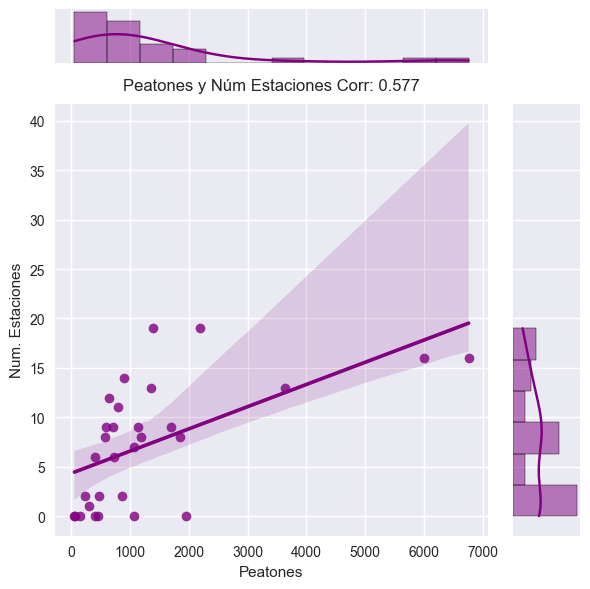

In [127]:
correlacion = np.corrcoef(resumen_500_agg['peatones'], resumen_500_agg['num_estaciones'])

plt.figure(figsize=(20,20))

sns.jointplot(data=resumen_500_agg, x="peatones", y="num_estaciones", kind="reg", color='purple');

plt.title(f'Peatones y Núm Estaciones Corr: {correlacion[0][1].round(3)}',pad=10);
plt.xlabel('Peatones')
plt.ylabel('Num. Estaciones')
plt.tight_layout()
plt.show()

Podemos ver que al tener un coeficiente de 0.577, se podría decir que tienen una correlación moderada entre el número de peatones y la cantidad de estaciones de BiciMAD, esto nos sugiere que las estaciones tienden a ubicarse en zonas con mayor flujo peatonal, aunque hay otras variables que también podrían influir.

In [128]:
calles_aforo = {}

for index, valor in enumerate(resumen_500_agg.values):
    val = [float(valor[2]), float(valor[3])]
    calles_aforo[valor[0]] = []
    calles_aforo[valor[0]].append(val)


estaciones_puntos = {}

for index, valor in enumerate(mapa_bases_bicicletas_geo.values):
    val = [float(valor[5]), float(valor[4])]
    estaciones_puntos[valor[0]] = []
    estaciones_puntos[valor[0]].append(val)


In [129]:
map = folium.Map(location=[40.4165, -3.70256], tiles="OpenStreetMap", zoom_start=12.5)

for k, punto in calles_aforo.items():
    folium.Circle(radius = 500, location = punto[0], color = '#0a15f0', fill_color = '#e3e4fc').add_to(map)
    folium.CircleMarker(location = punto[0], radius=2, color='red', fill=True, fill_color='red', fill_opacity=0.8, popup=k).add_to(map)



for k, punto in estaciones_puntos.items():
    folium.Marker(punto[0], 
                popup= k+ ':' + str(punto[0]), 
                icon=folium.Icon(icon='bicycle', prefix='fa')).add_to(map)


measure_control = plugins.MeasureControl(position='topleft', 
                                         active_color='red', 
                                         completed_color='red', 
                                         primary_length_unit='meters')

folium.Marker(location=[40.3881,  -3.7415], popup='Casa Hugo', icon=folium.Icon(color='green', icon='home', prefix='fa')).add_to(map)


map.add_child(folium.LatLngPopup())

map

## Hipotesis 2 Disponibilidad en horas pico

Para poder evaluar esta hipótesis tenemos 4 fuentes de datos (del ayuntamiento de Madrid) que nos ayudarán a comprobar si realmente esta hipótesis es cierta.

**1. Detalle de Aforo de personas en 2022** &rarr; Esta información nos detalle por calle, fecha y hora cuanto ha sido la concentración o aforo de peatones solo desde el mes de sep a dic (por cambios de métricas en el ayuntamiento). 

**2. Datos de la situación de estaciones bicimad por día y hora** &rarr; Esta información, actualizada en el 2022, nos detalla por cada estación de bicicletas por día y hora, su estado, su disponiblidad y detalles.

**3. Detalle de Bases de bicicletas en Madrid** &rarr; Esta información, actualizada en el 2020, nos detalla por cada estación de bicicletas su ubicación y detalles como anclajes.

**4. Detalle de Aforo de bicicletas en 2022** &rarr; Esta información nos detalle por calle, fecha y hora cuanto ha sido la concentración o aforo de bicicletas solo desde el mes de sep a dic (por cambios de métricas en el ayuntamiento). 

In [130]:
''' 
Lectura de fuentes de Datos

'''

aforo_personas_2022 = pd.read_csv('./data/Datos Tratados/aforo_personas_2022.csv')

sit_estaciones_2022 = pd.read_csv('./data/Datos Tratados/sit_estaciones_2022.csv')

aforo_bicicletas_2022 = pd.read_csv('./data/Datos Tratados/aforo_bicicletas_2022.csv')

# Fuente de las bases leído en anterior hipótesis

Ya que los datos del aforo solo tenemos datos desde septiembre hasta diciembre filtraremos la base de sit_estaciones_2022 en las mismas fechas y lo enriqueceremos los datos con información de la estación.

In [131]:
# Filtramos los datos para los meses mayores o iguales a septiembre.

sit_estaciones_2022 = sit_estaciones_2022[sit_estaciones_2022['mes']>=9]

In [132]:
# Unimos la información el maestro de estaciones

sit_estaciones_2022_detalle = pd.merge(sit_estaciones_2022, mapa_bases_bicicletas, on='cod_estacion', how='inner')

In [133]:
sit_estaciones_2022_detalle.drop(columns=['id_estacion', 'des_estacion', 'activate', 'plazas', 'distrito', 'barrio', 'fecha_hora', 'free_bases', 'fecha', 'hora_minuto'], inplace=True)

De este modo tenemos la información completa del estado de las estaciones.

Por otro lado, vamos a trabajar con las bases de aforos: Peatonales y Bicicletas.

In [134]:
# Nos quedamos con las columnas que nos interesan.

aforo_personas_2022.drop(columns=['fecha_hora', 'fecha', 'hora_min'], inplace=True)
aforo_bicicletas_2022.drop(columns=['fecha_hora', 'fecha', 'hora_min'], inplace=True)

In [135]:
aforo_personas_2022.describe()

,mes,hora,dia_semana,fin_semana,peatones,latitude,longitude
count,51402.000000,51402.000000,51402.000000,51402.000000,51402.000000,51402.000000,51402.000000
mean,10.537586,11.506906,3.051905,0.287187,926.648107,40.418520,-3.702147
std,1.118927,6.921750,2.003098,0.452454,1458.369156,0.006836,0.012191
min,9.000000,0.000000,0.000000,0.000000,0.000000,40.405367,-3.723948
25%,10.000000,6.000000,1.000000,0.000000,117.000000,40.413387,-3.707464
50%,11.000000,12.000000,3.000000,0.000000,444.000000,40.419908,-3.701798
75%,12.000000,18.000000,5.000000,1.000000,1054.000000,40.423803,-3.696471
max,12.000000,23.000000,6.000000,1.000000,65032.000000,40.432945,-3.649175


En una primera vista vemos que tenemos un amplio rango de datos por mes y hora del 2022. Con una media de 926.65 de peatones y su desviación es de 1458.37 lo que muestra que los datos son muy dispersos con respecto a la media. Además, miramos los datos de sus cuartiles,  la media y la mediana está muy alejadas y los valores max con el quartil 3 (75%) tambien lo que nos hace pensar que su distribución tiene una asimetría positiva con una larga cola a la derecha.

Para poder determinar que es una hora pico, vamos a estudiar la distribucion de los peatones por meses en las 24 horas.

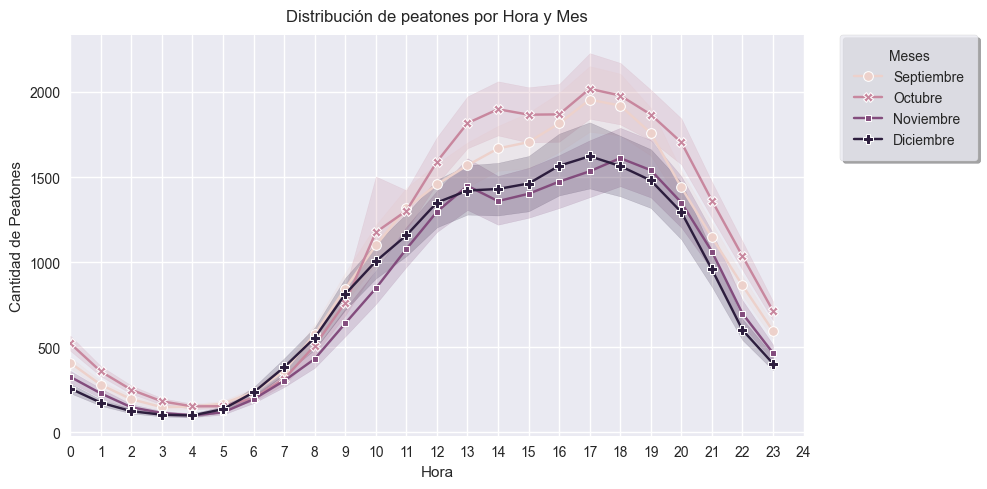

In [136]:
plt.figure(figsize=(10,5))

sns.lineplot(data=aforo_personas_2022, x="hora", y="peatones", hue="mes", markers=True,dashes=False, style="mes")
plt.title('Distribución de peatones por Hora y Mes', pad=10)

plt.xlabel('Hora')
plt.xlim(0, 24)
plt.ylabel('Cantidad de Peatones')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

new_labels = ['Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, new_labels, title='Meses', frameon = True, fancybox=True, framealpha=0.8, shadow=True, borderpad=1, bbox_to_anchor=(1.05, 1), 
           loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()

Como se puede ver en la gráfica, la franja de horas que tiene mayor ocupación de peatones es en dos rangos 12 - 14 horas y 17 a 19 horas para todos lo meses, excepto en septiembre que tiene un pico a las 10 am que no lo vamos a tomar.

Ahora esta información nos ayudará a enfocar específicamente en las horas de altos picos y entender como se conportan los peatones. 

Era de esperarse que esas horas sean la se alto flujo, ya que son las que representan la salida del almuerzo y salida de trabajo, para complemetar este análisis vamos a añadir un estudio de las distribuciones de cada hora.

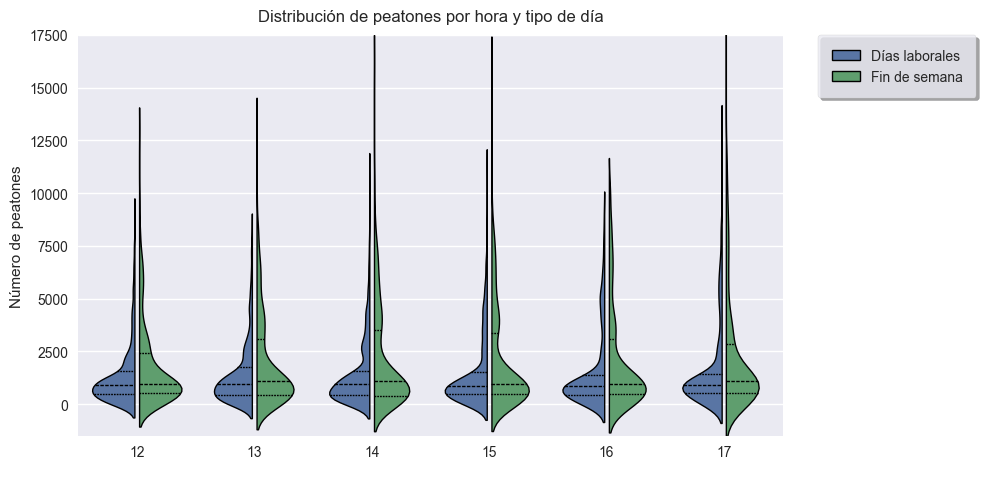

In [137]:
plt.figure(figsize=(10,5))

new_labels = ['Días laborales', 'Fin de semana']

sns.violinplot(data=aforo_personas_2022[aforo_personas_2022['hora'].isin([12, 13, 14, 15, 16, 17])], x='hora', 
               y='peatones', hue='fin_semana', split=True, gap=.1, inner="quart", order=[12, 13, 14, 15, 16, 17], linewidth=1, 
               linecolor="k")

plt.title('Distribución de peatones por hora y tipo de día', pad=10)
plt.xlabel(' ')
plt.ylabel('Número de peatones')
plt.ylim(-1500, 17500)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, new_labels, frameon = True, fancybox=True, framealpha=0.8, shadow=True, borderpad=1, bbox_to_anchor=(1.05, 1), 
           loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()

Añadiendo a esto, una de las medidas que vamos a utilizar para poder validar la hipótesis es la probabilidad que un peatón use una bicicleta. 

Para esto, usaremos las fuentes de aforo de bicicletas y personas para poder determinar un ratio de bicicletas/total de población y de este modo tendremos una probabilidad por hora.

In [138]:
# Creamos una fuente única de aforo de bicicletas y personas

aforo_personas = aforo_personas_2022[aforo_personas_2022['hora'].isin([12, 13, 14, 15, 16, 17])]
aforo_personas['tipo'] = 'peatones'
aforo_personas.rename(columns={'peatones':'num'}, inplace=True)

aforo_bicicletas = aforo_bicicletas_2022[aforo_bicicletas_2022['hora'].isin([12, 13, 14, 15, 16, 17])]
aforo_bicicletas['tipo'] = 'bicicletas'
aforo_bicicletas.rename(columns={'bicicletas':'num'}, inplace=True)

aforo_total_2022 = pd.concat([aforo_personas, aforo_bicicletas])

In [139]:
''' 
Una vez unificadas las fuentes vamos a crear el ratio del total de problación sobre el numero de biciletas
'''

aforo_por_tipo = aforo_total_2022.groupby(['tipo', 'hora', 'fin_semana'])[['num']].sum().reset_index()

aforo_total = aforo_total_2022.groupby(['hora', 'fin_semana'])[['num']].sum().reset_index()

ratios = pd.merge(aforo_por_tipo, aforo_total, on=['hora', 'fin_semana'], suffixes=('_tipo', '_total'))

ratios['porcentaje'] = ratios['num_tipo']/ratios['num_total']

ratios = ratios[ratios['tipo']=='bicicletas']

ratios

,tipo,hora,fin_semana,num_tipo,num_total,porcentaje
0,bicicletas,12,0,36331,2007850,0.018094
1,bicicletas,12,1,21661,1087861,0.019912
2,bicicletas,13,0,38558,2171280,0.017758
3,bicicletas,13,1,23243,1237832,0.018777
4,bicicletas,14,0,41921,2154672,0.019456
5,bicicletas,14,1,20379,1300828,0.015666
6,bicicletas,15,0,44003,2244897,0.019601
7,bicicletas,15,1,18569,1251691,0.014835
8,bicicletas,16,0,42955,2383822,0.018019
9,bicicletas,16,1,16805,1263499,0.013300


In [140]:
# Calculamos la media  agrupada por 'direccion', 'hora', 'fin_semana'.
aforo_personas_2022_hora = aforo_personas_2022[aforo_personas_2022['hora'].isin([12, 13, 14, 15, 16, 17])]

aforo_personas_2022_hora = aforo_personas_2022_hora.groupby(['direccion', 'longitude', 'latitude', 'hora', 'fin_semana'])['peatones'].mean().round(2).reset_index()

Por otro lado, usaremos la situación de las estaciones por dia y hora, para determinar si existía o no bicicletas disponibles y cuantas del total han sido alquiladas.

In [141]:
# Filtramos para que tengan las mismas horas de análisis y calculamos las medias de 'dispo_bikes', 'dock_bikes'

sit_estaciones_2022_detalle['dispo_bikes'] = sit_estaciones_2022_detalle['total_bases']-sit_estaciones_2022_detalle['dock_bikes']

sit_estaciones_2022_detalle_hora = sit_estaciones_2022_detalle[sit_estaciones_2022_detalle['hora'].isin([12, 13, 14, 15, 16, 17])]

sit_estaciones_2022_detalle_hora = sit_estaciones_2022_detalle_hora.groupby(['cod_estacion', 'longitud', 'latitud', 'hora', 'fin_semana'])[['dispo_bikes', 'dock_bikes']].mean().round(2).reset_index()

In [142]:
sit_estaciones_2022_detalle[sit_estaciones_2022_detalle['hora'].isin([12, 13, 14, 15, 16, 17])].groupby(['hora', 'fin_semana'])[['dispo_bikes']].describe()

dispo_bikes                                                  
                      count       mean       std  min   25%   50%   75%   max
hora fin_semana                                                              
12   0              22355.0  14.915902  5.789027  0.0  11.0  15.0  19.0  30.0
     1               8942.0  15.098747  5.648126  0.0  11.0  15.0  19.0  30.0
13   0              22618.0  14.961005  5.719287  0.0  11.0  16.0  19.0  30.0
     1               8942.0  15.221091  5.634249  0.0  11.0  16.0  20.0  30.0
14   0              22618.0  15.179724  5.390119  0.0  11.0  16.0  19.0  30.0
     1               8942.0  15.224782  5.645753  0.0  11.0  16.0  20.0  30.0
15   0              22881.0  15.169486  5.253482  0.0  12.0  16.0  19.0  30.0
     1               8942.0  15.070901  5.694797  0.0  11.0  16.0  19.0  30.0
16   0              22618.0  15.062163  5.253618  0.0  11.0  15.0  19.0  30.0
     1               8942.0  15.096064  5.662847  0.0  11.0  16.0  19.0  30.0
17   0              22355.0  15.132677  5.194286  0.0  12.0  15.0  19.0  30.0
     1               8942.0  15.170767  5.633835  0.0  11.0  16.0  20.0  30.0

Su distribuciones de bicis bastante estable y centralizada, pero hay momentos con vaciado total y diferencias pequeñas entre días laborables y fines de semana.

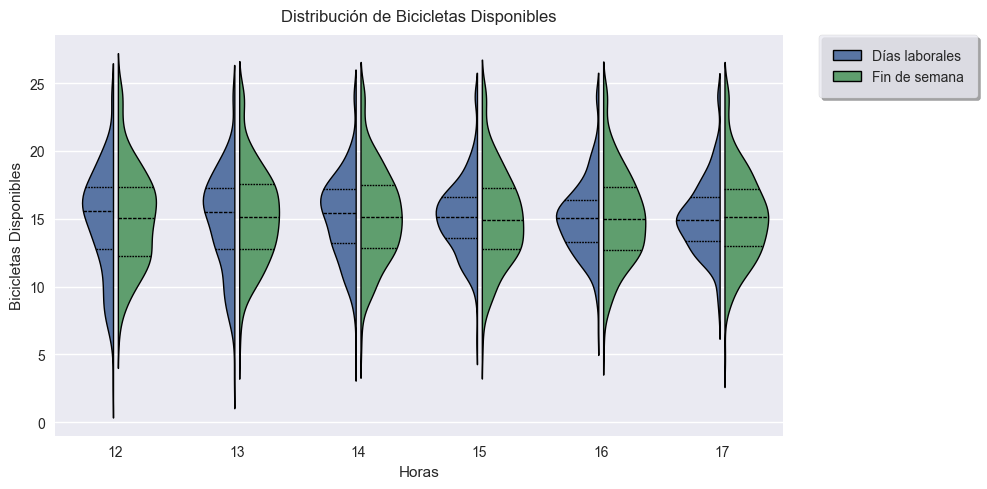

In [143]:
plt.figure(figsize=(10,5))


new_labels = ['Días laborales', 'Fin de semana']

sns.violinplot(data=sit_estaciones_2022_detalle_hora[sit_estaciones_2022_detalle_hora['hora'].isin([12, 13, 14, 15, 16, 17])], x='hora', 
               y='dispo_bikes', hue='fin_semana', split=True, gap=.1, inner="quart", order=[12, 13, 14, 15, 16, 17], linewidth=1, 
               linecolor="k")

plt.title('Distribución de Bicicletas Disponibles', pad=10)
plt.xlabel('Horas')
plt.ylabel('Bicicletas Disponibles')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, new_labels, frameon = True, fancybox=True, framealpha=0.8, shadow=True, borderpad=1, bbox_to_anchor=(1.05, 1), 
           loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()

Con estos datos podemos empezar a hacer un análisis espacial para determinar según estos puntos, cuantas estaciones se encuentran cerca y la disponibilidad de bicicletas. Para esto con la ayuda de geopandas vamos a codificar nuestras fuentes como un geo DataFrame con CRS.

**crs=**'EPSG:4326'

~~~

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

~~~

In [144]:
aforo_personas_2022_geo = gpd.GeoDataFrame(aforo_personas_2022_hora, geometry=gpd.points_from_xy(aforo_personas_2022_hora['longitude'], aforo_personas_2022_hora['latitude']), crs='EPSG:4326')
sit_estaciones_2022_geo = gpd.GeoDataFrame(sit_estaciones_2022_detalle_hora, geometry=gpd.points_from_xy(sit_estaciones_2022_detalle_hora['longitud'], sit_estaciones_2022_detalle_hora['latitud']), crs='EPSG:4326')

Una vez los datos están listos para medir las distancias, tenemos que generar para los puntos de aforo un buffer, lo que devuelve todos lo puntos posibles que existen a rededor de un punto a una distancia determinada. 

Pa esto probamos con una distancia de 500 metros que es equivalente a un ritmo estandar de caminata de 6 a 7 min ya que queremos mirar los puntos cercanos.

In [145]:
aforo_personas_2022_geo = aforo_personas_2022_geo.to_crs(epsg=25830) #cambiar lat y log a seudonimo en distancia en metros
sit_estaciones_2022_geo = sit_estaciones_2022_geo.to_crs(epsg=25830) #cambiar lat y log a seudonimo en distancia en metros

In [146]:
aforo_personas_2022_geo['buffer_500'] = aforo_personas_2022_geo.geometry.buffer(500)

In [147]:
aforo_personas_2022_geo_buffer = aforo_personas_2022_geo.set_geometry('buffer_500') #Cambiar para que los puntos de medida sea el buffer

In [148]:
result_500 = gpd.sjoin(sit_estaciones_2022_geo, aforo_personas_2022_geo_buffer, how='right', predicate='intersects')

result_500 = result_500[(result_500["hora_left"] == result_500["hora_right"]) & (result_500["fin_semana_left"] == result_500["fin_semana_right"])]

result_500.rename(columns={'hora_left':'hora',
                   'fin_semana_left':'fin_semana'}, inplace=True)

result_500.drop(columns=['hora_right','fin_semana_right', 'index_left'], inplace=True)

In [149]:
result_500_detalle = result_500.groupby(['direccion','hora', 'fin_semana', 'peatones'])[['dispo_bikes', 'dock_bikes','cod_estacion']].aggregate({'dispo_bikes': 'sum', 'dock_bikes':'sum', 'cod_estacion': 'count'}).reset_index()

In [150]:
result_500_detalle.rename(columns={'cod_estacion':'num_estaciones'}, inplace=True)

In [151]:
result_500_detalle['peatones'] = result_500_detalle['peatones'].round(0)
result_500_detalle['dispo_bikes'] = result_500_detalle['dispo_bikes'].round(0)
result_500_detalle['dock_bikes'] = result_500_detalle['dock_bikes'].round(0)
result_500_detalle['num_estaciones'] = result_500_detalle['num_estaciones'].round(0)

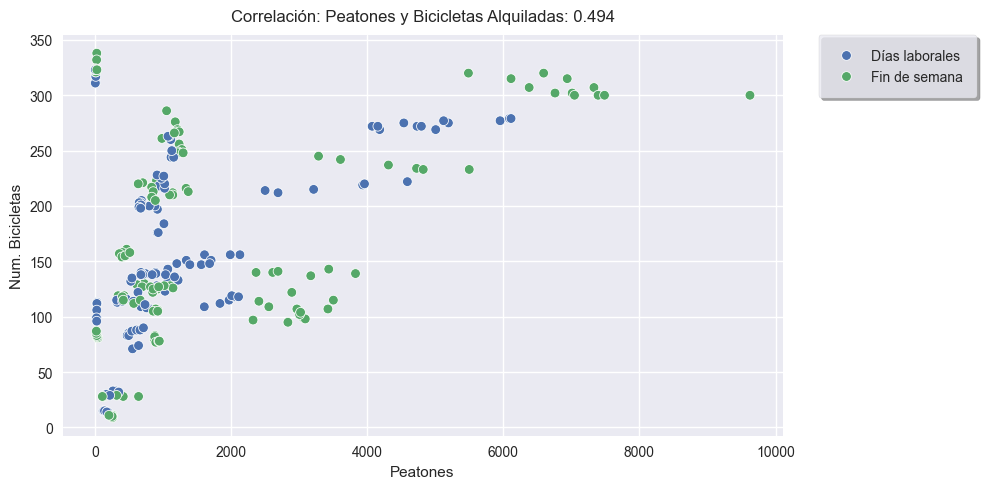

In [152]:
plt.figure(figsize=(10,5))

correlacion = np.corrcoef(result_500_detalle['peatones'], result_500_detalle['dispo_bikes'])

sns.scatterplot(x = result_500_detalle['peatones'], y = result_500_detalle['dispo_bikes'], hue=result_500_detalle['fin_semana'])
plt.title(f'Correlación: Peatones y Bicicletas Alquiladas: {correlacion[0][1].round(3)}', pad=10)
plt.xlabel('Peatones')
plt.ylabel('Num. Bicicletas')

new_labels = ['Días laborales', 'Fin de semana']
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, new_labels, frameon = True, fancybox=True, framealpha=0.8, shadow=True, borderpad=1, bbox_to_anchor=(1.05, 1), 
           loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()

Existe una relación positiva leve entre la cantidad de peatones y el número de bicicletas alquiladas. 

Aunque no es una relación perfecta, los datos nos sugieren que en momentos con más peatones, también tiende a haber mayor uso de bicicletas públicas. 

Además, se observa que los fines de semana pueden tener niveles altos de uso con menos peatones, posiblemente por entretenimiento o turismo.

Como un añadido a este análisis, usaremos el ratio calculado de porbabilidad de alquiler de bicicletas.

In [153]:
# Unimos las 2 fuentes

result_500_detalle = pd.merge(result_500_detalle, ratios.loc[:, ['hora', 'fin_semana', 'porcentaje']], on=['hora', 'fin_semana'])

In [154]:
''' 
Con estos ratios, vamos a crear una variable binaria de cumplimiento, para determinar en caso de que todos los peatones probables decidan alquilar 
una bicicleta tengan disponibles.

'''

result_500_detalle['uso'] = round(result_500_detalle['peatones'] * result_500_detalle['porcentaje'], 0)

cumplimiento = {'cumplimiento':[]}

for index, valor in enumerate(result_500_detalle.values):
    
    result = result_500_detalle.iloc[index, 5] < result_500_detalle.iloc[index, 8]
    if result == True:
        cumplimiento['cumplimiento'].append(0)
    else:
        cumplimiento['cumplimiento'].append(1)

result_500_detalle = pd.concat([result_500_detalle, pd.DataFrame(cumplimiento)],axis=1)

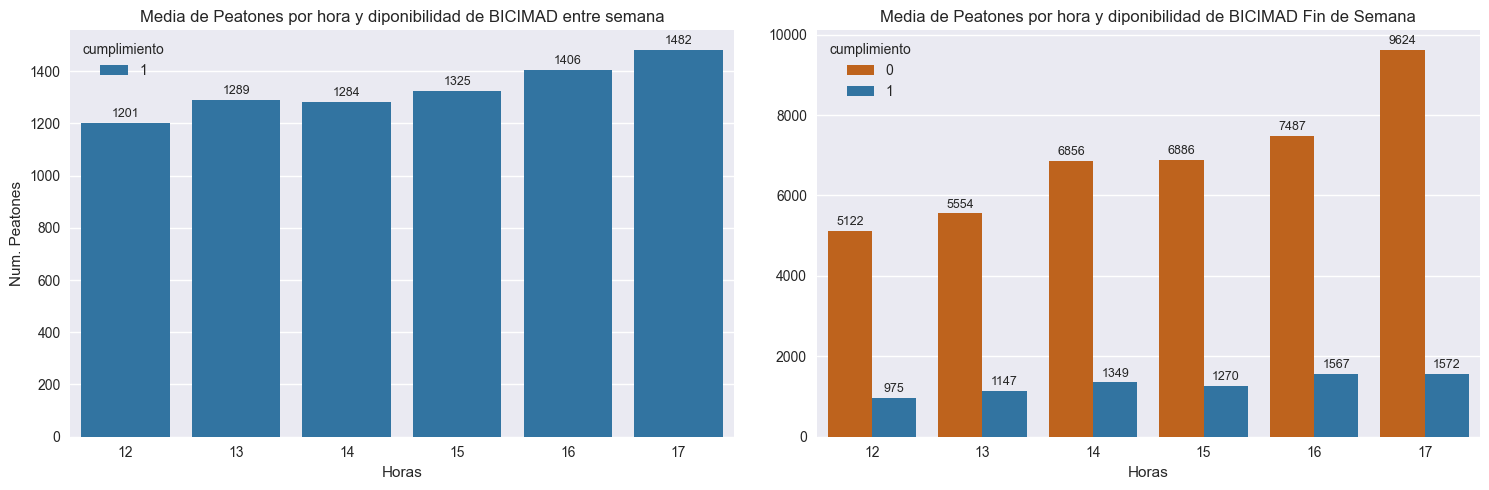

In [155]:
plt.figure(figsize=(15, 5))

palette_cumplimiento = {1: "#1f77b4", 0: "#d95f02"}

plt.subplot(1, 2, 1)
ax1 = sns.barplot(
    data=result_500_detalle[result_500_detalle['fin_semana'] == 0],
    x='hora', y='peatones', hue='cumplimiento', errorbar=None, palette=palette_cumplimiento)
plt.title('Media de Peatones por hora y diponibilidad de BICIMAD entre semana')
plt.xlabel('Horas')
plt.ylabel('Num. Peatones')


for container in ax1.containers:
    ax1.bar_label(container, fmt='%.0f', fontsize=9, padding=2)

plt.subplot(1, 2, 2)
ax2 = sns.barplot(
    data=result_500_detalle[result_500_detalle['fin_semana'] == 1],
    x='hora', y='peatones', hue='cumplimiento', errorbar=None, palette=palette_cumplimiento)
plt.title('Media de Peatones por hora y diponibilidad de BICIMAD Fin de Semana')
plt.xlabel('Horas')
plt.ylabel(' ')


for container in ax2.containers:
    ax2.bar_label(container, fmt='%.0f', fontsize=9, padding=2)

plt.tight_layout()
plt.show()

Es curioso que entre semana siempre a las horas pico existan bicicletas disponibles para la demanda, lo cual muestra que el servicio de BICIMAD, esta bien para los horarios pico entre semana.

## Hipotesis 3 Uso turistico del sistema

Para poder evaluar esta hipótesis tenemos 3 fuentes de datos (del ayuntamiento de Madrid) que nos ayudarán a comprobar si realmente esta hipótesis es cierta.

**1. Usuarios BICIMAD resumen 2022** &rarr; Esta información nos detalle por día las altas de usuarios por tipología de abonos.

**2. Resumen diario de uno de abonos del 2022** &rarr; Esta información nos detalla por tipo de abono el uso al día.

**3. Afluencia Turistas 2022** &rarr; Esta información nos detalla los meses de alta concentración turistica en la comunidad de Madrid.

In [156]:
''' 
Lectura de fuentes de Datos

'''

usuarios_bici_resumen_2022 = pd.read_csv('./data/Datos Tratados/usuarios_bici_resumen_2022.csv')

uso_bici_resumen_2022 = pd.read_csv('./data/Datos Tratados/uso_bici_resumen_2022.csv')

flujo_turistas_2022 = pd.read_csv('./data/Datos Tratados/turistas_2022.csv')

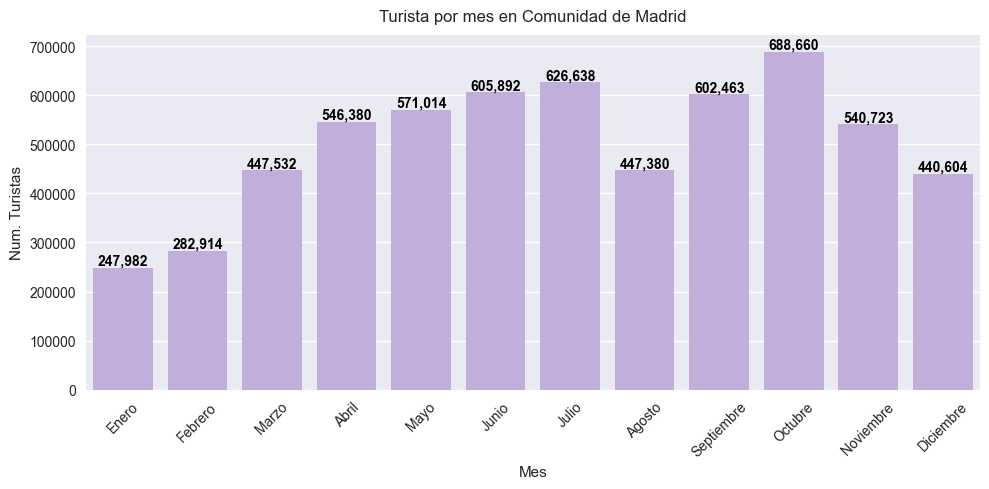

In [157]:
plt.figure(figsize=(10,5))

ax = sns.barplot(x = flujo_turistas_2022['mes'], y = flujo_turistas_2022['num_turistas'], errorbar=None, color='#c1a6e3')
plt.title('Turista por mes en Comunidad de Madrid', pad=10)
ax.bar_label(ax.containers[0], fontsize=10, fmt='{:,.0f}', color='black', fontweight='bold')
plt.xlabel('Mes')

plt.ylabel('Num. Turistas')
meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
plt.xticks(ticks=range(0, 12), labels=meses, rotation=45)

plt.tight_layout()
plt.show()

Según esta información de la comunidad de Madrid del año, se puede ver que es un patrón estacional con picos en julio y octubre por el verano, tiene un crecimiento  desde invierno hasta verano-otoño.

Por otro lado, si miramos los datos anuales de los usuarios de bicimad y el uso de sus abonos.

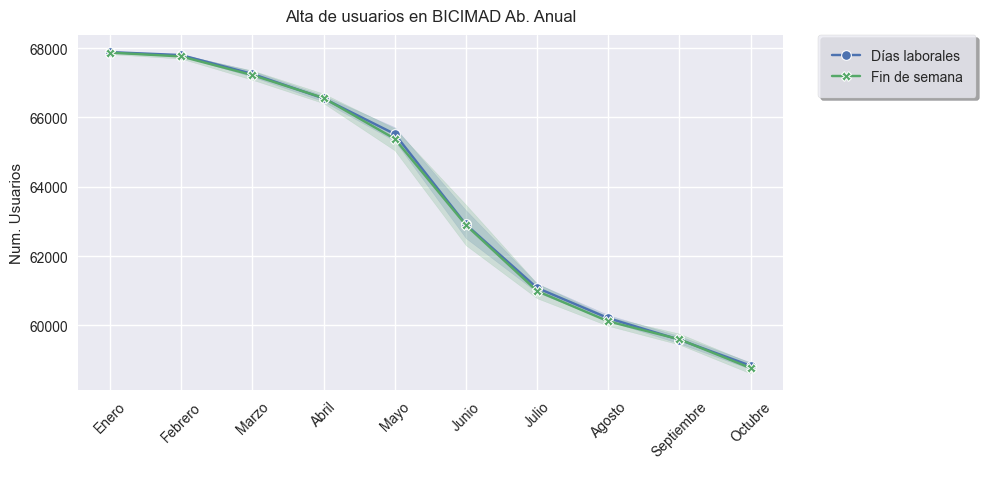

In [158]:
plt.figure(figsize=(10,5))

sns.lineplot(data=usuarios_bici_resumen_2022, x="mes", y="ab_anual_total", hue="fin_semana", markers=True,dashes=False, style="fin_semana")
plt.title('Alta de usuarios en BICIMAD Ab. Anual', pad=10)

plt.xlabel(' ')
plt.ylabel('Num. Usuarios')

new_labels = ['Días laborales', 'Fin de semana']
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, new_labels, frameon = True, fancybox=True, framealpha=0.8, shadow=True, borderpad=1, bbox_to_anchor=(1.05, 1), 
           loc='upper left', borderaxespad=0.)

meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre']
plt.xticks(ticks=range(1, 11), labels=meses, rotation=45)

plt.tight_layout()
plt.show()

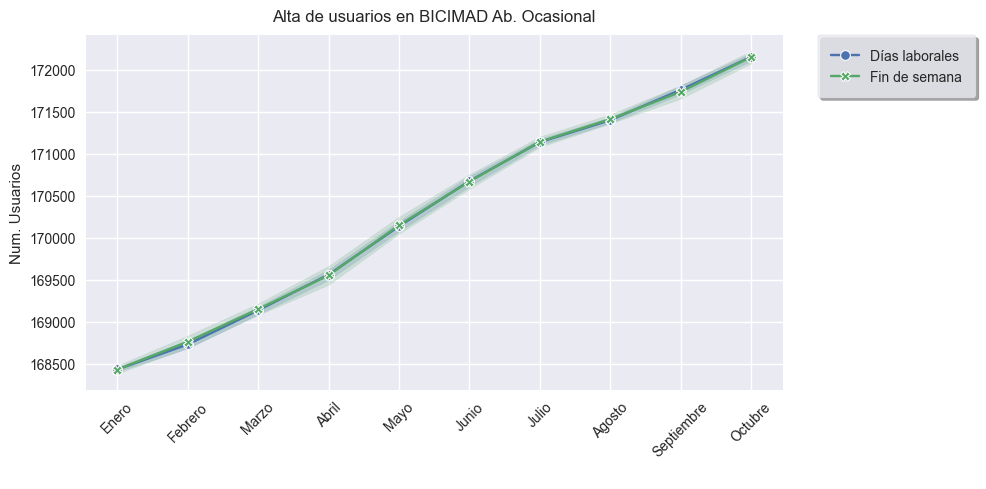

In [159]:
plt.figure(figsize=(10,5))

sns.lineplot(data=usuarios_bici_resumen_2022, x="mes", y="ab_ocas_total", hue="fin_semana", markers=True,dashes=False, style="fin_semana")
plt.title('Alta de usuarios en BICIMAD Ab. Ocasional', pad=10)

plt.xlabel(' ')
plt.ylabel('Num. Usuarios')

new_labels = ['Días laborales', 'Fin de semana']
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, new_labels, frameon = True, fancybox=True, framealpha=0.8, shadow=True, borderpad=1, bbox_to_anchor=(1.05, 1), 
           loc='upper left', borderaxespad=0.)

meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre']
plt.xticks(ticks=range(1, 11), labels=meses, rotation=45)

plt.tight_layout()
plt.show()

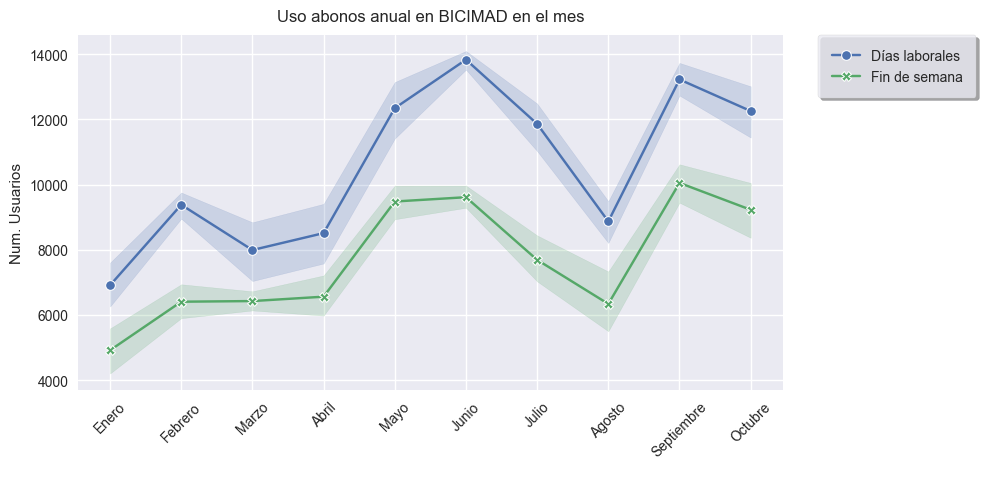

In [160]:
plt.figure(figsize=(10,5))

sns.lineplot(data=uso_bici_resumen_2022, x="mes", y="uso_ab_anual_dia", hue="fin_semana", markers=True,dashes=False, style="fin_semana")
plt.title('Uso abonos anual en BICIMAD en el mes', pad=10)

plt.xlabel(' ')
plt.ylabel('Num. Usuarios')

new_labels = ['Días laborales', 'Fin de semana']
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, new_labels, frameon = True, fancybox=True, framealpha=0.8, shadow=True, borderpad=1, bbox_to_anchor=(1.05, 1), 
           loc='upper left', borderaxespad=0.)

meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre']
plt.xticks(ticks=range(1, 11), labels=meses, rotation=45)

plt.tight_layout()
plt.show()

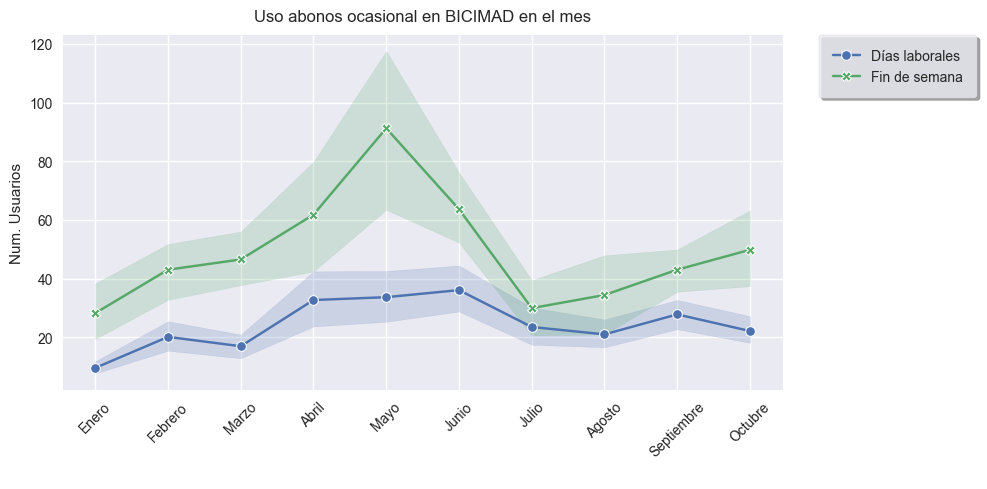

In [161]:
plt.figure(figsize=(10,5))

sns.lineplot(data=uso_bici_resumen_2022, x="mes", y="uso_ab_ocas_dia", hue="fin_semana", markers=True,dashes=False, style="fin_semana")
plt.title('Uso abonos ocasional en BICIMAD en el mes', pad=10)

plt.xlabel(' ')
plt.ylabel('Num. Usuarios')

new_labels = ['Días laborales', 'Fin de semana']
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, new_labels, frameon = True, fancybox=True, framealpha=0.8, shadow=True, borderpad=1, bbox_to_anchor=(1.05, 1), 
           loc='upper left', borderaxespad=0.)

meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre']
plt.xticks(ticks=range(1, 11), labels=meses, rotation=45)

plt.tight_layout()
plt.show()

Una vez echamos un vistazo del uso de los abonos y las altas, tenemos que crear un ratio o indicador de actividad por tipo de usuario para que el nos muestre el uso real de los abonos. 

In [162]:
#Ratios de uso de abono a fin de mes 

resumen_bicimad = pd.merge(uso_bici_resumen_2022.loc[:, ['mes', 'fin_semana', 'fecha', 'uso_ab_anual_dia', 'uso_ab_ocas_dia']], usuarios_bici_resumen_2022.loc[:, ['fecha', 'ab_anual_total', 'ab_ocas_total']],
                           on='fecha')

resumen_bicimad['ratio_ab_anual'] = resumen_bicimad['uso_ab_anual_dia']/resumen_bicimad['ab_anual_total']
resumen_bicimad['ratio_ab_ocasional'] = resumen_bicimad['uso_ab_ocas_dia']/resumen_bicimad['ab_ocas_total']

resumen_bicimad_fmes = pd.merge(resumen_bicimad, resumen_bicimad.groupby('mes')['fecha'].max().reset_index(), on=['mes', 'fecha'])

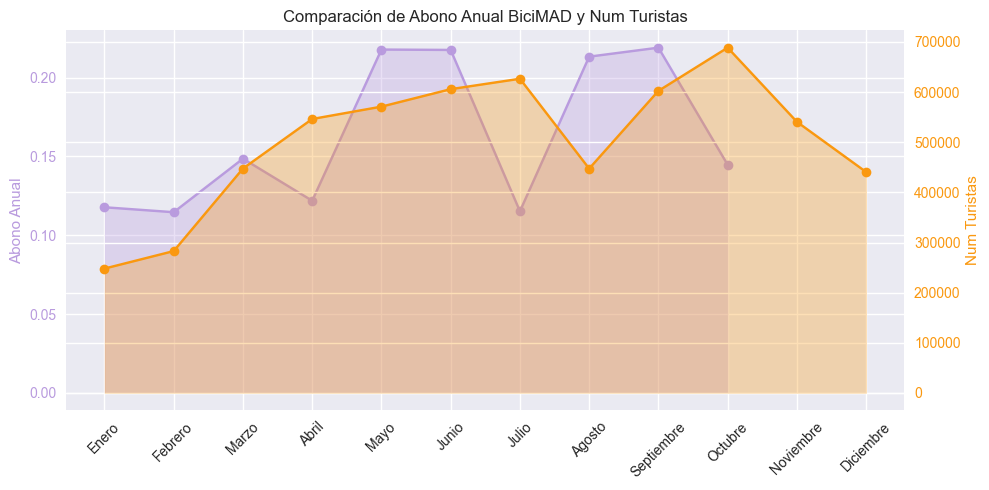

In [163]:
fig, ax1 = plt.subplots(figsize=(10, 5))

x1 = resumen_bicimad_fmes['mes']
y1 = resumen_bicimad_fmes['ratio_ab_anual']

x2 = flujo_turistas_2022['mes']
y2 = flujo_turistas_2022['num_turistas']

ax1.plot(x1, y1, color='#b99bde', label='Ratio Abono Anual', marker='o')
ax1.fill_between(x1, y1, color='#b99bde', alpha=0.3)
ax1.set_ylabel('Abono Anual', color='#b99bde')
ax1.tick_params(axis='y', labelcolor='#b99bde')
meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre']
plt.xticks(ticks=range(1, 11), labels=meses, rotation=45)

ax2 = ax1.twinx()
ax2.plot(x2, y2, color='#fa980f', label='Turistas', marker='o')
ax2.fill_between(x2, y2, color='#fa980f', alpha=0.3)
ax2.set_ylabel('Num Turistas', color='#fa980f')
ax2.tick_params(axis='y', labelcolor='#fa980f')
meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
plt.xticks(ticks=range(1, 13), labels=meses, rotation=45)


plt.title('Comparación de Abono Anual BiciMAD y Num Turistas')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
fig.tight_layout()
plt.show()


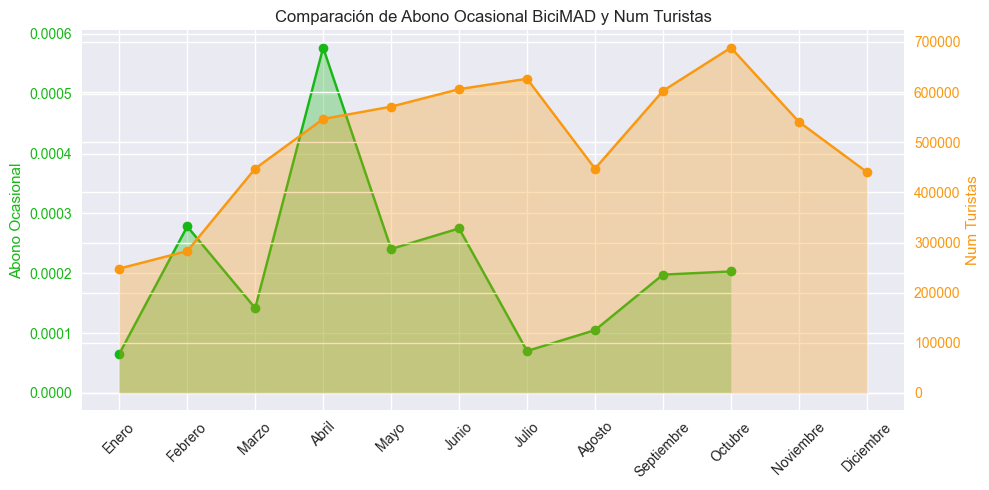

In [164]:
fig, ax1 = plt.subplots(figsize=(10, 5))

x1 = resumen_bicimad_fmes['mes']
y1 = resumen_bicimad_fmes['ratio_ab_ocasional']

x2 = flujo_turistas_2022['mes']
y2 = flujo_turistas_2022['num_turistas']

ax1.plot(x1, y1, color='#16b816', label='Ratio Abono Ocasional', marker='o')
ax1.fill_between(x1, y1, color='#16b816', alpha=0.3)
ax1.set_ylabel('Abono Ocasional', color='#16b816')
ax1.tick_params(axis='y', labelcolor='#16b816')
meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre']
plt.xticks(ticks=range(1, 11), labels=meses, rotation=45)

ax2 = ax1.twinx()
ax2.plot(x2, y2, color='#fa980f', label='Turistas', marker='o')
ax2.fill_between(x2, y2, color='#fa980f', alpha=0.3)
ax2.set_ylabel('Num Turistas', color='#fa980f')
ax2.tick_params(axis='y', labelcolor='#fa980f')
meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
plt.xticks(ticks=range(1, 13), labels=meses, rotation=45)


plt.title('Comparación de Abono Ocasional BiciMAD y Num Turistas')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
fig.tight_layout()
plt.show()


Lo que se puede ver es que no existe una correlación con el uso de los abonos con el turismos en si, a pesar de existir abonos ocacionales los turistas no se dan de alta en el proceso lo que nos dá a pensar que el uso de estos es estable.

## Hipotesis 4 Mayor uso en fines de semana

Para poder evaluar esta hipótesis tenemos 2 fuentes de datos (del ayuntamiento de Madrid) que nos ayudarán a comprobar si realmente esta hipótesis es cierta.

**1. Usuarios BICIMAD resumen 2022** &rarr; Esta información nos detalle por día las altas de usuarios por tipología de abonos.

**2. Resumen diario de uno de abonos del 2022** &rarr; Esta información nos detalla por tipo de abono el uso al día.

Usaremos una tabla resumen creada de la información de alta usuario por abono y uso de los mismos.

In [165]:
#Usamos fuentes ya utilizadas anteriormente

resumen_bicimad['total_usos'] = resumen_bicimad['uso_ab_anual_dia'] + resumen_bicimad['uso_ab_ocas_dia']
resumen_bicimad['total_usuarios'] = resumen_bicimad['ab_anual_total'] + resumen_bicimad['ab_ocas_total']
resumen_bicimad['ratio_total'] = resumen_bicimad['total_usos']/resumen_bicimad['total_usuarios']

In [166]:
resumen_bicimad['fecha'] = [datetime.strptime(i, '%Y-%m-%d') for i in resumen_bicimad['fecha']]

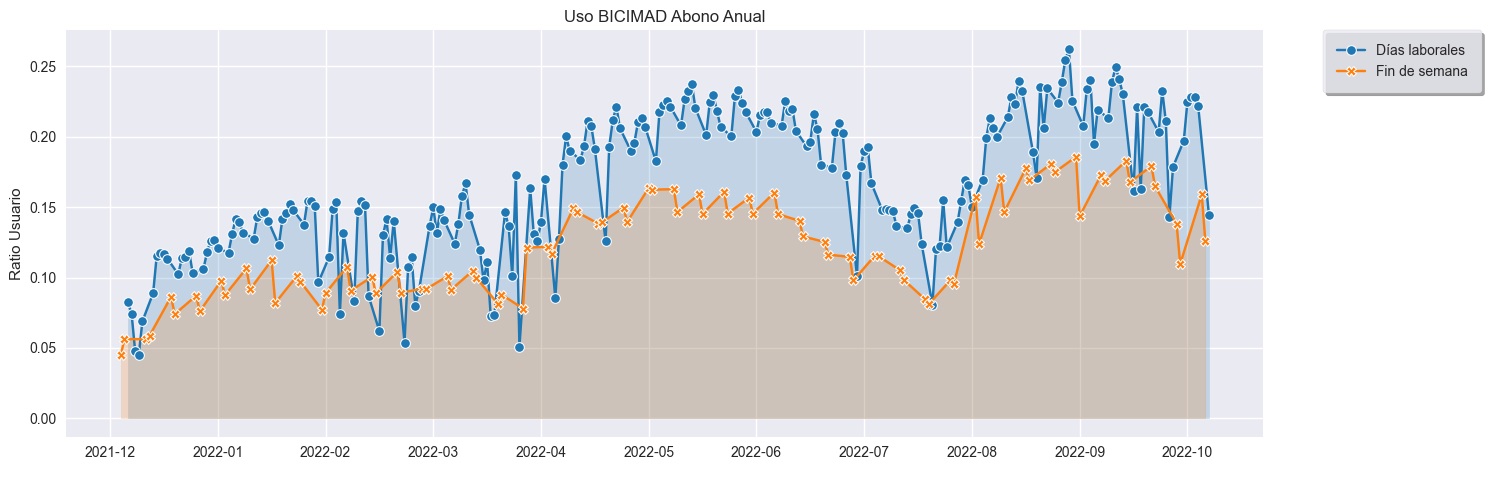

In [172]:
plt.figure(figsize=(15, 5))

palette = {0: '#1f77b4', 1: '#ff7f0e'}


ax = sns.lineplot( data=resumen_bicimad, x="fecha", y="ratio_ab_anual", hue="fin_semana", style="fin_semana", markers=True, dashes=False,  palette=palette)


for value, color in palette.items():
    grupo = resumen_bicimad[resumen_bicimad['fin_semana'] == value]
    plt.fill_between(grupo['fecha'], grupo['ratio_ab_anual'], alpha=0.2, color=color)


plt.title('Uso BICIMAD Abono Anual')
plt.xlabel(' ')
plt.ylabel('Ratio Usuario')

new_labels = ['Días laborales', 'Fin de semana']
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, new_labels, frameon = True, fancybox=True, framealpha=0.8, shadow=True, borderpad=1, bbox_to_anchor=(1.05, 1), 
           loc='upper left', borderaxespad=0.)

# ax.grid(False)

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(30))          
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 

plt.tight_layout()
plt.show()


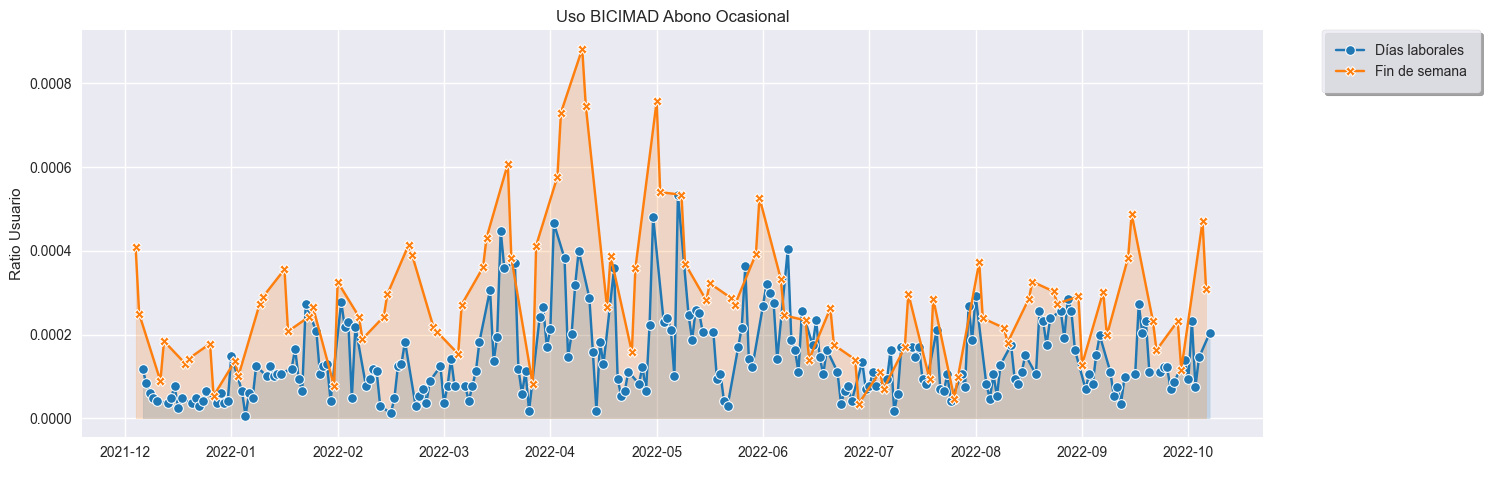

In [175]:
plt.figure(figsize=(15, 5))

palette = {0: '#1f77b4', 1: '#ff7f0e'}


ax = sns.lineplot( data=resumen_bicimad, x="fecha", y="ratio_ab_ocasional", hue="fin_semana", style="fin_semana", markers=True, dashes=False,  palette=palette)


for value, color in palette.items():
    grupo = resumen_bicimad[resumen_bicimad['fin_semana'] == value]
    plt.fill_between(grupo['fecha'], grupo['ratio_ab_ocasional'], alpha=0.2, color=color)

plt.title('Uso BICIMAD Abono Ocasional')
plt.xlabel(' ')
plt.ylabel('Ratio Usuario')

new_labels = ['Días laborales', 'Fin de semana']
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, new_labels, frameon = True, fancybox=True, framealpha=0.8, shadow=True, borderpad=1, bbox_to_anchor=(1.05, 1), 
           loc='upper left', borderaxespad=0.)

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(30))          
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 

plt.tight_layout()
plt.show()


Según la tipología del abono el uso de las bicletas y por lo tanto de sus abonos, depende del tipo. Los abonos Anuales, tienen un mayor uso en los días laborales o entre semana que a diferencia de abono ocacional qye se usan más en los fines de semana.